In [1]:
import mpld3

import sys
import os,bisect,scipy
import numpy as np
import pandas as pd
import geopy.distance as pydist
import time 

import matplotlib.pylab as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.dates import date2num 
import matplotlib.tri as tri
%matplotlib notebook
mpld3.enable_notebook()

plt.switch_backend("nbagg")
#plt.style.use('ggplot')
#plt.rcParams['figure.figsize'] = 40,40 #width,then height
plt.rcParams.update({'font.size': 18})
#plt.rcParams['savefig.dpi'] = 80

from obspy.clients.fdsn import Client
client = Client("IRIS")
from obspy import UTCDateTime
from obspy.signal.trigger import recursive_sta_lta
from obspy.signal.trigger import trigger_onset as triggerOnset
from obspy.taup import TauPyModel as TauP
i91 = TauP(model="iasp91")

import Util as Ut

#shush the chained assignment warning
pd.options.mode.chained_assignment = None

In [2]:
tt = UTCDateTime(2009,1,20,20,0)
ndays=int(1)

In [3]:
yr = tt.year
mo = tt.month
dy = tt.day
hr = tt.hour
mn = tt.minute
sc = tt.second
counter = tt.julday
counter_3char = str(counter).zfill(3)
dayat = int(dy)
homedir=''


#############################
t0 = time.time()
wb = 9 #which basin for station list import
tlength = 8800 #nsamples on either side of detection time for template
edgebuffer = 60 #seconds
duration=7200 # 2 hour images
duration = duration +edgebuffer
thresholdv= 1.7 #area threshold
delta = 40.0 # resample to this delta
nseconds = 7200
#stft params
npts = int(delta*(nseconds+edgebuffer))
fftsize=256
fftlen =int(np.floor((nseconds+edgebuffer)*delta/(fftsize/2)-1))
overlap=4   
hop = fftsize / overlap
w = scipy.hanning(fftsize+1)[:-1] 

#im = # 2 hour images to process
if duration == 86400 + edgebuffer:
    im = 12 #the entire day
elif duration == 7200 + edgebuffer:
    im=1 #just one image



#####################################################################
# Making the detections, in 2 hour data chunks, 1 day at a time
for days in range(ndays):
    plt.close('all')
    print(str(tt))

    ##########################
    bulk,blastsites = Ut.getbulk(wb,tt,duration)
    s = 'basin%s/'%wb+str(yr)+str('_')+counter_3char
    if not os.path.exists(s):
    	os.makedirs(s) 

    nptsf = edgebuffer*delta
    blockette = 0
    d = {'Contributor': 'NA', 'Latitude': 'NA','Longitude': 'NA', 'S1': 'NA',
         'S1time': 'NA', 'Magnitude': -999.00, 'mag_err': -999.00,'cent_er': -999.00,
         'Confidence': 0,'S2':'NA','S3':'NA','S4': 'NA', 'S5': 'NA','S6': 'NA',
         'S2time': 'NA','S3time': 'NA','S4time': 'NA','S5time': 'NA','S6time': 'NA',
         'Type': 'Event','AltLat': 'NA','AltLon': 'NA','AltTime': 'NA','idx': 'NA'}
    index = [0]; df1 = pd.DataFrame(data=d, index=index)   
 
    ##########################
    for block in range(im):
        t1=time.time()        
        inv= client.get_stations(starttime = tt, endtime = tt+nseconds+60,network='TA',station='*',location='--',channel = 'BHZ')
        sz = client.get_waveforms(network='TA', station= '*',location='--',
                        channel = 'BHZ', starttime=tt, endtime= tt+nseconds+60)
        print('It took '+str(time.time()-t1)+' seconds to gather the data')
        for i in range(len(sz)):
            if sz[i].stats.sampling_rate != delta:
                sz[i].resample(delta)
            #print("Reset Sample rate for station: ",sz[i].stats.station)
        
        
        sz.merge(fill_value=000)
        sz.detrend()
        sz.filter('highpass',freq=1.0)
        sz.taper(.001)
        inv=inv.networks[0]
        invlist = [x.code for x in inv]
        for i in range(len(sz)):
            sz[i].stats.location = [inv[np.where(np.array(invlist) == sz[i].stats.station) \
            [0][0]].latitude,inv[np.where(np.array(invlist) == sz[i].stats.station)[0][0]].longitude]
                          
        ll,lo,slist,vizray=[],[],[],[]
        shorty = 0
        for z in range(len(sz)):
            if sz[z].stats.npts >= npts:
                vizray.append([])
                Bwhite = Ut.w_spec(sz[z].data,delta,fftsize)
                vizray[shorty].append(np.sum(Bwhite[64:154,:fftlen-1],axis=0))
                ll.append(sz[z].stats.location[0])
                lo.append(sz[z].stats.location[1])
                slist.append(sz[z].stats.station)
                shorty = shorty+1
            
            
        rays = np.vstack(np.array(vizray))
        ix = np.where(np.isnan(rays))
        rays[ix] =0
        rayz=np.copy(rays)
        ll,lo,slist,rayz = Ut.reorder_arrays(ll,lo,slist,rayz)
        alltimes=Ut.gettvals(sz[0],sz[1],sz[2])
        timevector = Ut.getfvals(tt,np.shape(rayz)[1],nseconds,edgebuffer)

        #clean up the array 
        rayz = Ut.saturate_array(np.array(rayz))
        ix = np.where(np.isnan(rayz))
        rayz[ix] =0
       
        #determine which level to use as detections 4* MAD
        levels=[Ut.get_levels(rayz)]
        
        #unstructured triangular mesh with stations as verticies, mask out the long edges
        triang = tri.Triangulation(lo, ll)
        mask,edgeL = Ut.long_edges(lo,ll, triang.triangles)
        triang.set_mask(mask)
        kval=Ut.get_k(lo,ll,triang.triangles,thresholdv)

2009-01-20T20:00:00.000000Z
It took 99.92423486709595 seconds to gather the data


/Users/lisa/anaconda/envs/keras/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'mask'
  s)


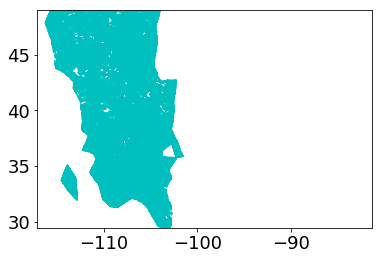

In [4]:
centroids,ctimes,ctimeindex=[],[],[]
for window,_ in enumerate(rayz[0,:]):
    cs=plt.tricontour(triang,rayz[0:,window], levels=levels)
    contour = cs.collections[0].get_paths()
    for alls,_ in enumerate(contour):
        vs=contour[alls].vertices
        area_of_cont =(Ut.polygon_area(vs))
        if area_of_cont > kval:
            centroids.append([Ut.get_centroid(vs)])
            ctimes.append(timevector[window])
            ctimeindex.append(window)
            
#%%     Filter peaks in av above threshold by time and distance to remove redundant.

nodes = list(zip(lo,ll))
localE,globalE,closesti=Ut.get_catalog_data(tt,nseconds,lo,ll)
#idx_trial,labels,af = Ut.chain_picks(idxx,coordinatesz,ctimes,centroids)
ctimeindex,ctimes,centroids= Ut.chain_picksby_timedist(ctimeindex,ctimes,centroids)
detections = idx = ctimeindex

In [5]:
if len(idx) > 0:
   
    localEnodes = list(zip(localE.Lon,localE.Lat,[float( \
    str(UTCDateTime(localE.DateString[x]).timestamp)[5:])/10.0 for x in range(len(localE))]))
    globalEnodes = list(zip(globalE.Lon,globalE.Lat,[float( \
    str(UTCDateTime(localE.DateString[x]).timestamp)[5:])/10.0 for x in range(len(localE))]))
     
    iii,tmplinklog,priorindex=[],[],-1
    if 'detections' in locals():
        index = range(len(detections))
    else: 
        index=[0]
        detections = []
    df = pd.DataFrame(data=d, index=index)
    ecount=0
    closest4plot=[]
    
    for i,val in enumerate(idx):
        #plt.clf()
        #plt.cla()
        mag=[]
        node = (centroids[i][0],centroids[i][1],float( \
        str(UTCDateTime(ctimes[i]).timestamp)[5:])/10.0)
        if len(localEnodes) > 0:
            tmplink = Ut.closest_node(node,localEnodes,1)[0]
            tmpdist = pydist.vincenty(localEnodes[tmplink][:2],node[:2]).meters/1000.0
            a,b = UTCDateTime(ctimes[i]),UTCDateTime(localE.DateString[tmplink])
            tmpdt = max(a,b) - min(a,b)
        closestl = Ut.closest_node(node[:2],nodes,6)
        closest4plot.append(closestl[0])
        #use STA/LTA to get time and 5 closest stations
        #mp,nf,cv,pdom = [],[],[],[]
        for all5 in range(6):
            #plt.subplot(6,1,all5+1)
            stg = slist[closestl[all5]]
            dfkey = 'S'+str(all5+1)
            dfkey2 = dfkey+'time'
            #get timeseries for this pick
            stg=slist[closestl[all5]]
            km = Ut.node_dist(node,nodes[closestl[all5]])
            timeindex=bisect.bisect_left(alltimes, ctimes[i])
            sss=sz.select(station=stg).copy().trim(UTCDateTime(ctimes[i])-220,
                UTCDateTime(ctimes[i])+220)
            clfdata=sz.select(station=stg).copy().trim(UTCDateTime(ctimes[i])-60,
                UTCDateTime(ctimes[i])+60)
            clfdata.taper(.01)
            sss.taper(.01)
            tseries = sss[0].data
            nsta,nlta = 60,800
            #cf=carl_sta_trig(tseries, nsta, nlta,.8,.8)
            #peaks = triggerOnset(cf, 10, -15)
            cf=recursive_sta_lta(tseries, int(40), int(1200))
            peaks = triggerOnset(cf, 3, .2)
            #use the clf model to predict class
            #mp.append(Ut.max_period(clfdata[0].data))
            #nf.append(Ut.central_frequency_unwindowed(clfdata[0].data,40.0))
            #cv.append(Ut.central_deriv(clfdata[0].data))
            #get rid of peaks that are way off LTX times
            if len(peaks) != 0:
                times = [sss[0].stats.starttime + x[0]/40.0 for x in peaks]    
                ki =bisect.bisect(times,UTCDateTime(ctimes[i]))
                if ki != 0:
                    ki = ki-1
                firstpeak =sss[0].stats.starttime + (peaks[ki][0]/40.0)
                if peaks[ki][0] > 7500 and peaks[ki][0] < 8800:
                    mdur = (peaks[ki][1]-peaks[ki][0])/delta
                    mag.append(-2.25+2.32*np.log10(mdur)+0.0023*km)
                     
                else:
                    firstpeak = UTCDateTime(ctimes[i])
            else:
                firstpeak = UTCDateTime(ctimes[i])
            #pdata=sss[0].copy().trim(UTCDateTime(firstpeak)-1,
            #    UTCDateTime(firstpeak)+1)
            #pdom.append(Ut.cent_freq(pdata[0].data,40))
            df[dfkey][ecount]= stg
            df[dfkey2][ecount] = firstpeak
             #plot picks on a figure with waveforms
            #plt.plot(Ut.gettvals(clfdata[0],clfdata[0],clfdata[0]),clfdata[0].data,c='k')
            #plt.axvline(firstpeak.datetime)
            #plt.text(firstpeak.datetime,1,stg,color='r',fontsize=50)

        df.Confidence[ecount] = 0#clf.predict(np.reshape(tmpfeat,[1,4]))[0]  
        df.Latitude[ecount] = node[1]
        df.Longitude[ecount] = node[0]
        df.idx[ecount] = i
        df.Magnitude[ecount] = np.median(mag)
        #plt.text((UTCDateTime(firstpeak.datetime)-30).datetime,0,
        #   'ALL: '+str(clf.predict(np.reshape(tmpfeat,[1,4]))[0]),color='red',fontsize=50)
        #svname=homedir+str(s)+"/image"+str(block)+"_pick_"+str(ecount+1)+".eps"
        #plt.savefig(svname,format='eps')
        #plt.clf()
        if len(localE) > 0 and tmpdt < 80 and tmpdist < 2*edgeL/1000.0:
            #iii.append(i);tmplinklog.append(tmplink)
            df.Contributor[ecount] = 'ANF,CDC'
            
            df.AltLat[ecount] = localE.Lat[tmplink]
            df.AltLon[ecount] = localE.Lon[tmplink]
            df.AltTime[ecount] = b
            df.mag_err[ecount] = df.Magnitude[ecount] - localE.ml[tmplink]
            df.Magnitude[ecount] = str(df.Magnitude[ecount])+','+str(localE.ml[tmplink])
            df.cent_er[ecount] = tmpdist
        else:
            df.Contributor[ecount] = 'CDC'
            if globalEnodes:
                tmplink = Ut.closest_node(node,globalEnodes,1)[0]
                #dep = globalE.depth[tmplink]
                #dit = loc2d(globalE.Lat[tmplink],globalE.Lon[tmplink],node[1],node[0])
                #arrivals = i91.get_travel_times(dep,dit)
                arrivalt = i91.get_travel_times_geo(globalE.depth[tmplink],globalE.Lat[tmplink],
                                         globalE.Lon[tmplink],node[0],node[1])[0].time
                try:
                    a,b = UTCDateTime(ctimes[i])+arrivalt,UTCDateTime(globalE.DateString[tmplink])
                    tmpdt = max(a,b) - min(a,b)
                    if tmpdt < 45:
                        df.Type[ecount] ='peripheral'
                except TypeError:
                    pass
                
        ecount+=1

/Users/lisa/anaconda/envs/keras/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/lisa/anaconda/envs/keras/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [36]:
df

AltLat   AltLon                      AltTime  Confidence Contributor  \
0        NA       NA                           NA           0         CDC   
1   44.3877 -105.412  2009-01-20T20:11:19.078000Z           0     ANF,CDC   
2        NA       NA                           NA           0         CDC   
3        NA       NA                           NA           0         CDC   
4        NA       NA                           NA           0         CDC   
5        NA       NA                           NA           0         CDC   
6   36.5368 -108.508  2009-01-20T20:16:07.961000Z           0     ANF,CDC   
7        NA       NA                           NA           0         CDC   
8        NA       NA                           NA           0         CDC   
9   46.0112 -112.476  2009-01-20T20:28:20.671000Z           0     ANF,CDC   
10       NA       NA                           NA           0         CDC   
11  44.1389  -105.43  2009-01-20T20:56:50.987000Z           0     ANF,CDC   
12   44.178 -105.364  2009-01-20T20:59:06.450000Z           0     ANF,CDC   
13       NA       NA                           NA           0         CDC   
14       NA       NA                           NA           0         CDC   
15  43.5314  -105.32  2009-01-20T21:11:05.953000Z           0     ANF,CDC   
16  43.7226 -105.313  2009-01-20T21:12:50.233000Z           0     ANF,CDC   
17       NA       NA                           NA           0         CDC   
18  44.0844 -105.421  2009-01-20T21:22:45.924000Z           0     ANF,CDC   
19       NA       NA                           NA           0         CDC   
20  43.7552 -105.261  2009-01-20T21:56:11.474000Z           0     ANF,CDC   
21       NA       NA                           NA           0         CDC   

   Latitude Longitude           Magnitude    S1                       S1time  \
0   44.3008  -105.628                 NaN  H23A  2009-01-20T20:03:02.621331Z   
1   44.4462  -105.425   2.19761395841,2.3  H23A  2009-01-20T20:11:38.446494Z   
2   39.1401  -105.794             2.59634  P23A  2009-01-20T20:12:55.339686Z   
3    41.589   -110.51             1.66217  M17A  2009-01-20T20:13:08.155218Z   
4   33.5106  -110.083           0.0809207  Y18A  2009-01-20T20:14:15.436761Z   
5    44.016  -105.403             1.26402  I23A  2009-01-20T20:14:10.650000Z   
6   36.4639  -108.972  1.50855532572,2.08  U19A  2009-01-20T20:16:20.125000Z   
7   33.5954  -109.704            0.727087  Y18A  2009-01-20T20:24:08.155116Z   
8   33.3208  -109.196             2.25336  Z20A  2009-01-20T20:28:18.675000Z   
9    45.893  -112.439             nan,1.8  F15A  2009-01-20T20:28:37.281288Z   
10  46.1199  -105.985             1.37983  E22A  2009-01-20T20:49:34.875000Z   
11  44.1257  -105.424  2.24886743001,2.73  I23A  2009-01-20T20:57:11.358693Z   
12  44.0295  -105.492  1.78584577099,2.42  I23A  2009-01-20T20:59:12.300000Z   
13  33.5883  -109.458             3.41318  Y19A  2009-01-20T21:02:34.950876Z   
14  44.4671  -105.471             2.40757  H23A  2009-01-20T21:04:30.290664Z   
15  43.5738  -105.478  2.84690457998,2.13  J23A  2009-01-20T21:11:26.795454Z   
16  43.8422  -105.438  1.63900067832,2.84  I23A  2009-01-20T21:13:12.523593Z   
17  38.7055  -105.394             1.04134  Q24A  2009-01-20T21:14:07.824998Z   
18  43.9809    -105.5  2.32379441607,2.51  I23A  2009-01-20T21:23:08.445831Z   
19   44.524  -105.726             1.79373  H23A  2009-01-20T21:26:17.624998Z   
20  43.7615  -105.549            nan,2.09  I23A  2009-01-20T21:56:37.280472Z   
21  38.7118  -104.887            0.873439  Q24A  2009-01-20T21:59:39.901803Z   

       ...        S4                       S4time    S5  \
0      ...      J23A  2009-01-20T20:03:02.621331Z  G23A   
1      ...      H24A  2009-01-20T20:11:38.446494Z  H22A   
2      ...      R23A  2009-01-20T20:12:55.339686Z  P24A   
3      ...      L17A  2009-01-20T20:12:58.474998Z  N17A   
4      ...      118A  2009-01-20T20:14:10.200000Z  Y19A   
5      ...      I24A  2009-01-20T20:14

In [92]:
plt.rcParams['figure.figsize'] = 10,8 #width,then height
fig, ax = plt.subplots()


for i in range(len(globalE)):
    ax.scatter(date2num(UTCDateTime(globalE.time[i]).datetime),1,s=150, color='b', alpha=.8)
for i in range(len(localE)):
    ax.scatter(date2num(UTCDateTime(localE.time[i]).datetime),closesti[i],s=150,facecolor='cyan',edgecolor='grey',alpha=.8)
ax.imshow(np.flipud(rayz),extent = [date2num(tt.datetime), date2num((tt + nseconds + edgebuffer).datetime),  0, len(slist)],
             aspect='auto',interpolation='none',cmap='bone',vmin=np.min(rayz)/2,vmax=np.max(rayz)*2)

x = [date2num(UTCDateTime(df.iloc[i].S1time).datetime) for i in range(len(df))]
y = [closest4plot[i] for i in range(len(df))]
scat=ax.scatter(x,y,s=200,color='white',facecolor='white',alpha=.4)

ax.xaxis_date()
plt.xlabel('UTC Time')
plt.ylabel('Station Name (interactive content)')
plt.yticks(np.arange(len(ll)))
ax.set_yticklabels(slist)
tdate = str(yr)+'-'+str(mo)+'-'+str(dayat).zfill(2)
plt.title(tdate)
#ax.grid(color='black')
labels = ['idx {0}'.format(i + 1) for i in range(len(df))]
tooltip = mpld3.plugins.PointLabelTooltip(scat, labels=labels)
mpld3.plugins.connect(fig, tooltip)
mpld3.display()
